In this notebook I benchmark a few text categorization models to test whehter word embeddings like word2vec can improve text classification accuracy. The the notebook proceeds as follows:
1. downloading the datasets
2. construction of the training set
3. definitions of models
4. benchmarking models
5. plotting results

This notebook was converted to Python 3 by <a href='https://github.com/marcelobeckmann'>@marcelobeckmann</a>

Tested with Python 3.5.3. The results are the same from the notebook for Python 2.

Downloading datasets and pretrained wector embeddings. Especially the embeddings can take a while to download. You might want run these in the terminal instead to see wget's progress bar. If you're on Windows (and not in cygwin) %%bash cell magic won't work and you'll have to do all this manually (or with %%cmd magic I guess). 

In [27]:
%%bash
# download Reuters' text categorization benchmarks
wget http://www.cs.umb.edu/~smimarog/textmining/datasets/r8-train-no-stop.txt
wget http://www.cs.umb.edu/~smimarog/textmining/datasets/r8-test-no-stop.txt
# concatenate train and test files, we'll make our own train-test splits
cat r8-*-no-stop.txt > r8-no-stop.txt
wget http://www.cs.umb.edu/~smimarog/textmining/datasets/r52-train-no-stop.txt
wget http://www.cs.umb.edu/~smimarog/textmining/datasets/r52-test-no-stop.txt
cat r52-*-no-stop.txt > r52-no-stop.txt
wget http://www.cs.umb.edu/~smimarog/textmining/datasets/20ng-test-no-stop.txt
wget http://www.cs.umb.edu/~smimarog/textmining/datasets/20ng-train-no-stop.txt
cat 20ng-*-no-stop.txt > 20ng-no-stop.txt

In [ ]:
import zipfile
# download GloVe word vector representations
# bunch of small embeddings - trained on 6B tokens - 822 MB download, 2GB unzipped
wget http://nlp.stanford.edu/data/glove.6B.zip
zip = zipfile.ZipFile('unzip glove.6B.zip')
zip.extractall()

# and a single behemoth - trained on 840B tokens - 2GB compressed, 5GB unzipped
wget http://nlp.stanford.edu/data/glove.840B.300d.zip
zip = zipfile.ZipFile('glove.840B.300d.zip')
zip.extractall()

In [1]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

# TRAIN_SET_PATH = "20ng-no-stop.txt"
# TRAIN_SET_PATH = "r52-all-terms.txt"
TRAIN_SET_PATH = "r8-no-stop.txt"

GLOVE_6B_50D_PATH = "glove.6B.50d.txt"
GLOVE_840B_300D_PATH = "glove.840B.300d.txt"
encoding="utf-8"

C:\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X, y = [], []
with open(TRAIN_SET_PATH, "r") as infile:
    for line in infile:
        label, text = line.split("\t")
        # texts are already tokenized, just split on space
        # in a real case we would use e.g. spaCy for tokenization
        # and maybe remove stopwords etc.
        X.append(text.split())
        y.append(label)
X, y = np.array(X), np.array(y)
print ("total examples %s" % len(y))

total examples 7674


Prepare word embeddings - both the downloaded pretrained ones and train a new one from scratch

In [3]:
import numpy as np
with open(GLOVE_6B_50D_PATH, "rb") as lines:
    wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}
    
    


In [4]:
# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our training set
# if you wan't to play around with the vectors and have 
# enough RAM - remove the 'if' line and load everything

import struct 

glove_small = {}
all_words = set(w for words in X for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

            
glove_big = {}
with open(GLOVE_840B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if word in all_words:
            nums=np.array(parts[1:], dtype=np.float32)
            glove_big[word] = nums
            



In [5]:
# train word2vec on all the texts - both training and test set
# we're not using test labels, just texts so this is fine
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}


In [6]:
print(len(all_words))


22931


Time for model definitions

In [7]:
# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
# SVM - which is supposed to be more or less state of the art 
# http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf
svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

Now the meat - classifiers using vector embeddings. We will implement an embedding vectorizer - a counterpart of CountVectorizer and TfidfVectorizer - that is given a word -> vector mapping and vectorizes texts by taking the mean of all the vectors corresponding to individual words.

In [19]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [9]:
# Extra Trees classifier is almost universally great, let's stack it with our embeddings
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])


benchmark all the things!

In [10]:
all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
    ("glove_small", etree_glove_small),
    ("glove_small_tfidf", etree_glove_small_tfidf),
    ("glove_big", etree_glove_big),
    ("glove_big_tfidf", etree_glove_big_tfidf),

]


unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


print (tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model                score
-----------------  -------
svc_tfidf           0.9656
svc                 0.9562
w2v_tfidf           0.9540
w2v                 0.9524
mult_nb             0.9467
glove_big           0.9283
glove_small         0.9230
glove_small_tfidf   0.9082
glove_big_tfidf     0.9058
mult_nb_tfidf       0.8615
bern_nb             0.7954
bern_nb_tfidf       0.7954


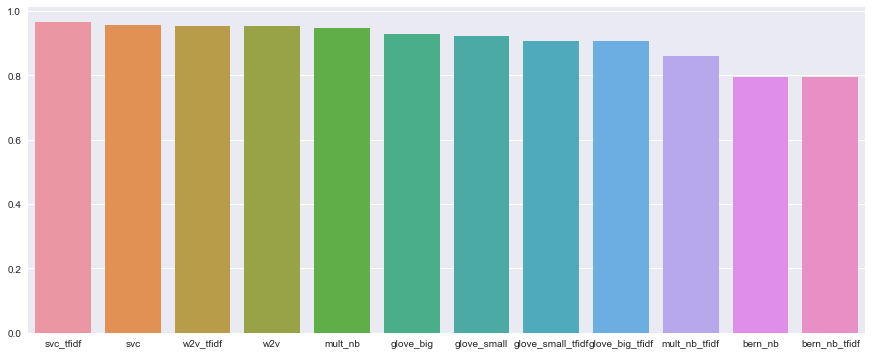

In [11]:
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

ok, this is how it is. Let's see how the ranking depends on the amount of training data. Word embedding models which are semi-supervised should shine when there is very little labeled training data

In [12]:
def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    for train, test in StratifiedShuffleSplit(y, n_iter=5, test_size=test_size):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

In [13]:
train_sizes = [10, 40, 160, 640, 3200, 6400]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)

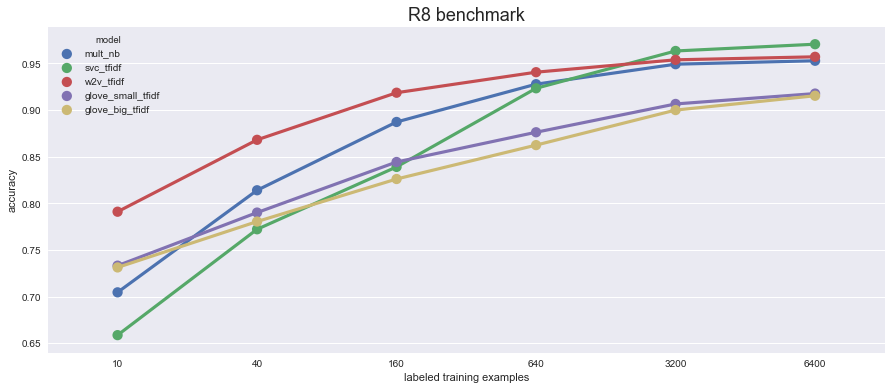

In [14]:
plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["mult_nb", "svc_tfidf", "w2v_tfidf", 
                                                         "glove_small_tfidf", "glove_big_tfidf", 
                                                        ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="R8 benchmark")
fig.set(ylabel="accuracy")

Let's be lazy and instead of refactoring, just copy the above code changing the input path to reuters 52

total examples 9100


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_l

model                score
-----------------  -------
svc_tfidf           0.9384
svc                 0.9204
w2v_tfidf           0.8920
w2v                 0.8832
mult_nb             0.8740
glove_big           0.8611
glove_small         0.8563
glove_small_tfidf   0.8414
glove_big_tfidf     0.8346
mult_nb_tfidf       0.7257
bern_nb             0.6668
bern_nb_tfidf       0.6668


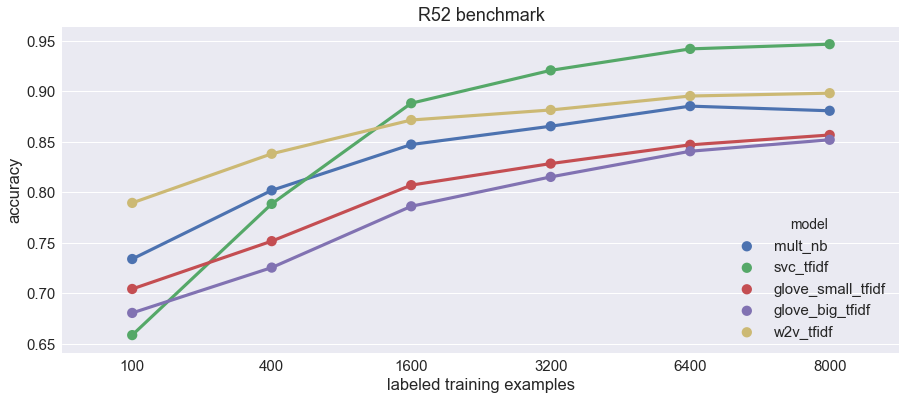

In [15]:
TRAIN_SET_PATH = "r52-no-stop.txt"

X, y = [], []
with open(TRAIN_SET_PATH, "r") as infile:
    for line in infile:
        label, text = line.split("\t")
        # texts are already tokenized, just split on space
        # in a real case we would use e.g. spaCy for tokenization
        # and maybe remove stopwords etc.
        X.append(text.split())
        y.append(label)
X, y = np.array(X), np.array(y)
print ("total examples %s" % len(y))


# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our training set
# if you wan't to play around with the vectors and have 
# enough RAM - remove the 'if' line and load everything

glove_small = {}
all_words = set(w for words in X for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums
            
glove_big = {}
with open(GLOVE_840B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_big[word] = nums
            
            
            
# train word2vec on all the texts - both training and test set
# we're not using test labels, just texts so this is fine
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}



# Extra Trees classifier is almost universally great, let's stack it with our embeddings
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])




all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("glove_small", etree_glove_small), 
    ("glove_small_tfidf", etree_glove_small_tfidf),
    ("glove_big", etree_glove_big), 
    ("glove_big_tfidf", etree_glove_big_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
]

unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))


train_sizes = [100, 400, 1600, 3200, 6400, 8000]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)


plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["mult_nb", "svc_tfidf", "w2v_tfidf", 
                                                         "glove_small_tfidf", "glove_big_tfidf", 
                                                        ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="R52 benchmark")
fig.set(ylabel="accuracy")

And now the 20 news group dataset 

total examples 11293
model                score
-----------------  -------
svc_tfidf           0.8861
mult_nb             0.8544
mult_nb_tfidf       0.8505
svc                 0.7889
glove_big           0.7494
glove_big_tfidf     0.7489
bern_nb             0.6878
bern_nb_tfidf       0.6878
glove_small         0.6686
glove_small_tfidf   0.6633
w2v_tfidf           0.5011
w2v                 0.4579


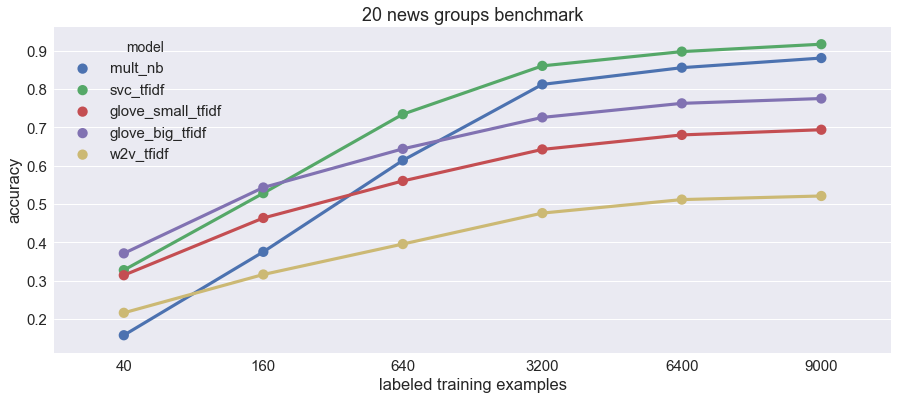

In [17]:
TRAIN_SET_PATH = "20ng-no-stop.txt"

X, y = [], []
with open(TRAIN_SET_PATH, "r") as infile:
    for line in infile:
        label, text = line.split("\t")
        # texts are already tokenized, just split on space
        # in a real case we would use e.g. spaCy for tokenization
        # and maybe remove stopwords etc.
        X.append(text.split())
        y.append(label)
X, y = np.array(X), np.array(y)
print ("total examples %s" % len(y))


# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our training set
# if you wan't to play around with the vectors and have 
# enough RAM - remove the 'if' line and load everything

glove_small = {}
all_words = set(w for words in X for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums
            
glove_big = {}
with open(GLOVE_840B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_big[word] = nums
            
            
            
# train word2vec on all the texts - both training and test set
# we're not using test labels, just texts so this is fine
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}



# Extra Trees classifier is almost universally great, let's stack it with our embeddings
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])




all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("glove_small", etree_glove_small), 
    ("glove_small_tfidf", etree_glove_small_tfidf),
    ("glove_big", etree_glove_big), 
    ("glove_big_tfidf", etree_glove_big_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
]

    
unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


print (tabulate(scores, floatfmt=".4f", headers=("model", 'score')))



train_sizes = [40, 160, 640, 3200, 6400, 9000]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)


plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["mult_nb", "svc_tfidf", "w2v_tfidf", 
                                                         "glove_small_tfidf", "glove_big_tfidf", 
                                                        ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="20 news groups benchmark")
fig.set(ylabel="accuracy")